In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import csv
import re
from utils import *
from vhparser import *

Imports. `vhparser` includes parsing code that is too long to reasonably include in this notebook. `utils` contains some utility code I tend to just copy between projects.

In [2]:
entries = getListOfEntries("virushostdb.tsv")
myEntries = MyVHDB.fromVHDBEntries(entries)

Obtain the list of entries in the VirusHost Database and parse it into a better format.

Number of unique Viruses: 11040
Number of unique Hosts:   3119


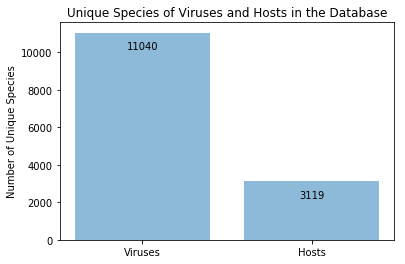

In [3]:
def countHosts(myvhdb):
    counter = Counter()
    for key, record in myvhdb.items():
        for host in record.hosts:
            counter.add(host.name, 1)

    return counter

hostCounter = countHosts(myEntries)
print("Number of unique Viruses: %d" % len(myEntries.keys()))
print("Number of unique Hosts:   %d" % hostCounter.numPresentKeys())
      
def makeUniqueVirusesHostsPlot(uniqueViruses, uniqueHosts):
    cats = ('Viruses', 'Hosts')
    y_pos = np.arange(len(cats))
    x_pos = (uniqueViruses, uniqueHosts)

    fig, ax = plt.subplots()

    bars = ax.bar(y_pos, x_pos, align='center', alpha = 0.5, tick_label=cats)
    ax.set_xticks(y_pos, cats)
    ax.set_ylabel('Number of Unique Species')
    ax.set_title('Unique Species of Viruses and Hosts in the Database')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height-1000, '%d' % int(height), ha='center', va='bottom')
        
makeUniqueVirusesHostsPlot(len(myEntries.keys()), hostCounter.numPresentKeys())

This code determines the number of unique species of both virus and host and spits out a bar graph comparing them. As we can see, there are around 3.5 times as many distinct species of virus that have been sequenced than there are species which play host to viruses that have been sequenced.

Mean number of host species per virus species: 1.288677536231884
Median number of host species per virus species: 1.0


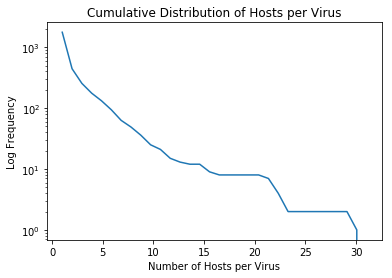

In [4]:
def hostsPerVirusPlot(myEntries):
    counts = []
    largest = 0
    for key, record in myEntries.items():
        count = len(record.hosts)
        if count > largest:
            largest = count 
        counts.append( float(count) )

    countsArray = np.array(counts)
    bins = np.arange(largest)
    
    print("Mean number of host species per virus species: %s" % np.mean(countsArray))
    print("Median number of host species per virus species: %s" % np.median(countsArray))

    fig, ax = plt.subplots()

    values, base = np.histogram(countsArray, bins=largest)
    cumulative = np.cumsum(values)
    ax.plot(base[:-1], len(countsArray)-cumulative)
    ax.set_yscale('log')

    ax.set_ylabel('Log Frequency')
    ax.set_xlabel('Number of Hosts per Virus')
    ax.set_title('Cumulative Distribution of Hosts per Virus')
    
hostsPerVirusPlot(myEntries)

This code generates a cumulative distribution of the number of different hosts infected by each virus species in the database. As we can see, this data is massively skewed towards the lower end, and tapers off exponentially, with only around a 10 species out 11,040 having a number of hosts in double digits.

Species name: Mus musculus	Count: 138
Species name: Bos taurus	Count: 182
Species name: Homo sapiens	Count: 1309
Species name: Sus scrofa	Count: 178
Species name: Solanum lycopersicum	Count: 261
Species name: Escherichia coli	Count: 185
Species name: Pseudomonas aeruginosa	Count: 113
Species name: Mycolicibacterium smegmatis MC2 155	Count: 446
Species name: Mycolicibacterium smegmatis	Count: 234
Species name: Staphylococcus aureus	Count: 101
1797


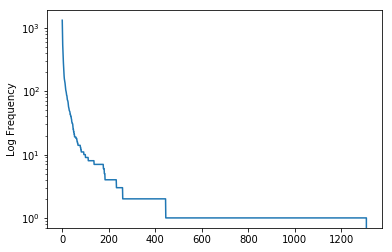

In [31]:
def virusesPerHostSpeciesPlot(myEntries):
    host_to_virus_dict = {}
    for virus_tax_id, record in myEntries.items():
        for host in record.hosts:
            if host.tax_id == '1': # filter out environmental samples
                continue
            elif host.name not in host_to_virus_dict.keys():
                host_to_virus_dict[host.name] = [virus_tax_id]
            else:
                if virus_tax_id not in host_to_virus_dict[host.name]:
                    host_to_virus_dict[host.name] = host_to_virus_dict[host.name] + [virus_tax_id]
    
    counts = []
    largest = 0
    single_virus_count = 0
    for host_tax_id in host_to_virus_dict.keys():
        count = len(host_to_virus_dict[host_tax_id])
        counts.append(float(count))
        if (count > largest):
            largest = count
        if count == 1:
            single_virus_count = single_virus_count + 1
        if count > 100:
            print("Species name: %s\tCount: %d" % (host_tax_id, count))
        
    print(single_virus_count)    
        
    countsArray = np.array(counts)
    bins = np.arange(largest)
    
    fig, ax = plt.subplots()

    values, base = np.histogram(countsArray, bins=largest)
    cumulative = np.cumsum(values)
    ax.plot(base[:-1], len(countsArray)-cumulative)
    ax.set_yscale('log')

    ax.set_ylabel('Log Frequency')
    ax.set_xlabel('Number of Viruses per Host Species')
    ax.set_title('Cumulative Distribution of Viruses per Host')
    
virusesPerHostSpeciesPlot(myEntries)

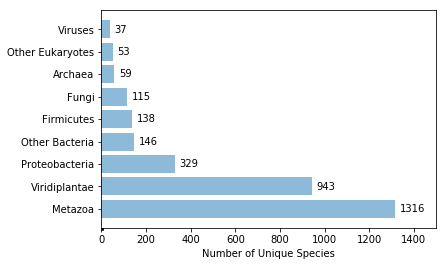

In [5]:
def pcc_sort(item):
    return item[1]

def hostCladesPlot(myEntries):
    countedHostIds = []
    cladeCounter = Counter()
    for virus_tax_id, record in myEntries.items():
        for host in record.hosts:
            if host.tax_id not in countedHostIds:
                countedHostIds.append(host.tax_id)
                splitLineage = host.lineage.split('; ')
                if len(splitLineage) < 2:
                    continue
                cladeCounter.add((splitLineage[0], splitLineage[1]), 1)

    prunedCladeCounter = Counter()
    for (clade1, clade2), count in cladeCounter.items():
        if count > 100:
            prunedCladeCounter.add( (clade1, clade2), count )
        else:
            prunedCladeCounter.add( (clade1, clade1), count )
    
    pcc_items = sorted(list(prunedCladeCounter.items()), key=pcc_sort, reverse=True)
    
    clades = []
    counts = []
    for (clade1, clade2), count in pcc_items:
        clade = None
        if (clade2 == 'Eukaryota'):
            clade = 'Other Eukaryotes'
        elif (clade2 == 'Bacteria'):
            clade = 'Other Bacteria'
        else:
            clade = clade2
        clades.append(clade)
        counts.append(count)

    fig, ax = plt.subplots()

    y_pos = np.arange(len(clades))
    bars = ax.barh(y_pos, counts, align='center', alpha=0.5, tick_label=clades)
    ax.set_xticks(y_pos, clades)
    ax.set_xlabel('Number of Unique Species')
    ax.set_xlim(0, 1500)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 20, bar.get_y() + bar.get_height()/2., '%d' % int(width), ha='left', va='center')
        
hostCladesPlot(myEntries)

The code above breaks down the clades to which different host species belong, and displays them as a bar graph. As we can see, the vast majority of sequenced hosts are either plants or animals, followed by bacteria, followed by fungi, followed by archaea, followed by other eukaryotes, followed by hosts that are, themselves, viruses.

Number of viruses which infect species of a single top-level clade: 9743
Number of viruses which infect species of multiple top-level clades: 139


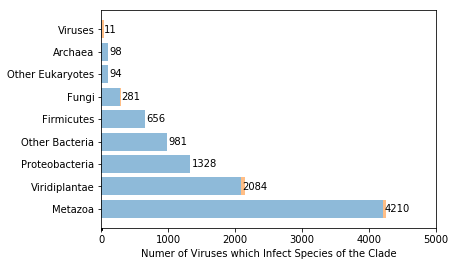

In [6]:
CLADES = {"Fungi", "Firmicutes", "Proteobacteria", "Viridiplantae", "Metazoa"}

def virusInfectsCladesPlot(myEntries):
    virus_to_host_clades_dict = {}
    for virus_tax_id, record in myEntries.items():
        for host in record.hosts:
            split_lineage = host.lineage.split('; ')
            if len(split_lineage) < 2:
                continue
            clade = split_lineage[1]
            if clade not in CLADES:
                if split_lineage[0] == 'Eukaryota':
                    clade = 'Other Eukaryotes'
                elif split_lineage[0] == 'Bacteria':
                    clade = 'Other Bacteria'
                else:
                    clade = split_lineage[0]
                
            if virus_tax_id not in virus_to_host_clades_dict.keys():
                virus_to_host_clades_dict[virus_tax_id] = [clade]
            elif clade not in virus_to_host_clades_dict[virus_tax_id]:
                virus_to_host_clades_dict[virus_tax_id] = virus_to_host_clades_dict[virus_tax_id] + [clade]
                
    single_clades_counter = Counter()
    multiple_clades_counter = Counter()
    for virus_tax_id, host_clades in virus_to_host_clades_dict.items():
        if len(host_clades) == 0:
            print("SOMETHING WENT TERRIBLY WRONG!")
            break
        elif len(host_clades) == 1:
            single_clades_counter.add(host_clades[0], 1)
        else:
            for clade in host_clades:
                multiple_clades_counter.add(clade, 1)
                
    dual_counter = single_clades_counter.clone()
    dual_counter.extend(multiple_clades_counter)
    
    dcc_items = sorted( list(dual_counter.items()), key=pcc_sort, reverse=True )
    
    clades = []
    for clade, count in dcc_items:
        clades.append(clade)
        
    single_counts = []
    multiple_counts = []
    for clade in clades:
        single_counts.append(single_clades_counter.get(clade))
        multiple_counts.append(multiple_clades_counter.get(clade))

    fig, ax = plt.subplots()
    
    y_pos = np.arange(len(clades))
    
    s_bars = ax.barh(y_pos, single_counts, align='center', alpha=0.5, tick_label=clades)
    m_bars = ax.barh(y_pos, multiple_counts, align='center', alpha=0.5, left = single_counts)
    ax.set_xticks(y_pos, clades)
    ax.set_xlabel("Numer of Viruses which Infect Species of the Clade")
    ax.set_xlim(0, 5000)
    
    for bar in s_bars:
        width = bar.get_width()
        plt.text(width + 20, bar.get_y() + bar.get_height()/2., '%d' % int(width), ha='left', va='center')
        
    print("Number of viruses which infect species of a single top-level clade: %d" % single_clades_counter.sum())
    print("Number of viruses which infect species of multiple top-level clades: %d" % multiple_clades_counter.sum())

virusInfectsCladesPlot(myEntries)
    
    
        

Number of Viruses that Infect at Least One Metazoan: 4254
Number of Viruses that Infect At Least One Domesticated Animal Host: 384
Number of Viruses that Infect Humans: 1310
Number of Viruses that Infect Both: 19
Number of viruses that infect at least one plant: 2141
Number of viruses that infect at least one domesticated plant: 1250


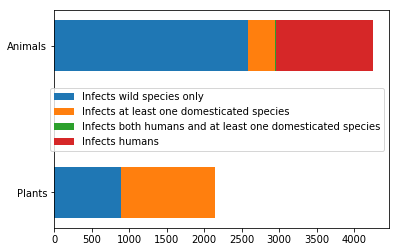

In [7]:
# Name records sometimes abbreviate the genus name (e.g. "A. mellifera") and sometimes contain multiple species in the format "speciesA x speciesB x ...".
# Also, sometimes "sp." or "spp." is used instead of the name of a specific species.
# This method extracts all names and possible abbreviations for them.
def getSpeciesNamesFromNameRecord(name):
    #species_names = name.split(" x ")
    species_names = re.split(" x |, ", name)
    orig_length = len(species_names)
    for species_name in species_names[:orig_length]:
        split_name = species_name.split(' ')
        if len(split_name) > 1:
            abbrev_genus = "{}.".format(split_name[0][0])
            for n in split_name[1:]:
                abbrev_genus = "{} {}".format(abbrev_genus, n)
            
            species_names.append(abbrev_genus)
            
            sp_genus = "{} sp.".format(split_name[0])
            spp_genus = "{} spp.".format(split_name[0])
            species_names.append(sp_genus)
            species_names.append(spp_genus)
    
    return species_names

def getDomesticatedAnimals(infile):
    domesticated_animals = []
    
    with open(infile) as dafile:
        reader = csv.reader(dafile)
        domesticated_animals = list(reader)[0]
            
    return domesticated_animals;

DOMESTICATED_ANIMALS = getDomesticatedAnimals("Domesticated-Animals.csv")

def countInfectsAtLeastOneMetazoan(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            if 'Metazoa' in host.lineage:
                count = count + 1
                break
                
    return count

def countInfectsAtLeastOneDomesticatedAnimal(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            counted = False
            host_names = getSpeciesNamesFromNameRecord(host.name)
            for host_name in host_names:
                if (host_name in DOMESTICATED_ANIMALS):
                    counted = True
                    
            if counted: count = count + 1
    
    return count

def countInfectsHumans(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            counted = False
            host_names = getSpeciesNamesFromNameRecord(host.name)
            for host_name in host_names:
                if host_name == "Homo sapiens" or "Homo" in host.lineage or "Homo" in host_name:
                    counted = True
                    
            if counted: count = count + 1
                    
    
    return count

def countInfectsHumansAndAtLeastOneDomesticatedAnimal(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        hum = False
        dom = False
        for host in record.hosts:
            counted = False
            host_names = getSpeciesNamesFromNameRecord(host.name)
            for host_name in host_names:
                if host_name == "Homo sapiens" or "Homo" in host.lineage or "Homo" in host_name:
                    hum = True
                elif host_name in DOMESTICATED_ANIMALS:
                    dom = True
        if hum and dom:
            count = count + 1
            
    return count

infects_at_least_one_metazoan = countInfectsAtLeastOneMetazoan(myEntries)
infects_at_least_one_domesticated_animal = countInfectsAtLeastOneDomesticatedAnimal(myEntries)
infects_humans = countInfectsHumans(myEntries)
infects_humans_and_at_least_one_domesticated_animal = countInfectsHumansAndAtLeastOneDomesticatedAnimal(myEntries)

print("Number of Viruses that Infect at Least One Metazoan: %d" % infects_at_least_one_metazoan)
print("Number of Viruses that Infect At Least One Domesticated Animal Host: %d" % infects_at_least_one_domesticated_animal)
print("Number of Viruses that Infect Humans: %d" % infects_humans)
print("Number of Viruses that Infect Both: %d" % infects_humans_and_at_least_one_domesticated_animal)

def getDomesticatedPlants(infile):
    domesticated_plants = []
    
    with open(infile) as dpfile:
        reader = csv.reader(dpfile)
        for line in reader:
            species_names = line[1].split(', ')
            for name in  species_names:
                if name not in domesticated_plants:
                    domesticated_plants.append(name)
            
    return domesticated_plants

DOMESTICATED_PLANTS = getDomesticatedPlants("allplants.csv")

def countInfectsAtLeastOnePlant(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            if 'Viridiplantae' in host.lineage:
                count = count + 1
                break
    
    return count

def countInfectsAtLeastOneDomesticatedPlant(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            counted = False
            host_names = getSpeciesNamesFromNameRecord(host.name)
            for host_name in host_names:
                if (host_name in DOMESTICATED_PLANTS):
                    counted = True
                    
            if counted: count = count + 1
    
    return count

infects_at_least_one_plant = countInfectsAtLeastOnePlant(myEntries)
infects_at_least_one_domesticated_plant = countInfectsAtLeastOneDomesticatedPlant(myEntries)

print("Number of viruses that infect at least one plant: {}".format(infects_at_least_one_plant))
print("Number of viruses that infect at least one domesticated plant: {}".format(infects_at_least_one_domesticated_plant))


def plotInfectsWhat(total_animals, humans, domesticated_animals, both, total_plants, domesticated_plants):
    wild_animals = total_animals - (humans + domesticated_animals - both)
    wild_plants = total_plants - domesticated_plants
    wild = (wild_plants, wild_animals)
    
    only_domestic_animals = domesticated_animals - both
    domestic = (domesticated_plants, only_domestic_animals)
    
    only_humans = humans - both
    pair_humans = (0, only_humans)
    pair_both   = (0, both)
    
    ind = np.arange(2)
    
    fig, ax = plt.subplots()
    pWild     = ax.barh(ind, wild,        height=0.35, align='center')
    pDomestic = ax.barh(ind, domestic,    height=0.35, align='center', left=wild)
    pBoth     = ax.barh(ind, pair_both,   height=0.35, align='center', left=(wild[0]+domestic[0], wild[1]+domestic[1]) )
    pHumans   = ax.barh(ind, pair_humans, height=0.35, align='center', left=(wild[0]+domestic[0]+pair_both[0], wild[1]+domestic[1]+pair_both[1]) )
    
    ax.legend( (pWild, pDomestic, pBoth, pHumans), ("Infects wild species only", "Infects at least one domesticated species", "Infects both humans and at least one domesticated species", "Infects humans"))
    plt.yticks(ind, ("Plants", "Animals"))
    
plotInfectsWhat(infects_at_least_one_metazoan, infects_humans, infects_at_least_one_domesticated_animal, infects_humans_and_at_least_one_domesticated_animal, infects_at_least_one_plant, infects_at_least_one_domesticated_plant)